In [1]:
# source source.me before launching jupyter
# export DWAVE_API_TOKEN=DEV-7dfad1c79ca4cac893a1541f6d04fbb3c2dced5c

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
Wed Jun 14 06:11:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 31%   41C    P2    52W / 250W |   1265MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir("/home/jtoledo/CaloQVAE/")
sys.path.insert(1, '/home/' + getpass.getuser() + '/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys

import torch
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[06:11:37.713] INFO   CaloQVAE                                          Willkommen!
[06:11:37.716] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

2023-06-14 06:11:42,056 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[06:11:42.056] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
# GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:
# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")

/usr/local/lib/python3.8/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [8]:
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')

[06:11:44.158] ERROR  wandb.jupyter                                     Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [9]:
modelCreator = ModelCreator(cfg=config)

In [10]:
dataMgr = DataManager(cfg=config)

In [11]:
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

[06:11:47.901] INFO   data.dataManager                                  Loading Data
[06:11:48.754] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f9c2e7acd90>: 94387 events, 738 batches
[06:11:48.755] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f9c2e783d00>: 11798 events, 12 batches
[06:11:48.757] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f9c2e77a280>: 11799 events, 12 batches


In [12]:
if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

In [13]:
#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)


[06:11:52.518] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasCRBMCNN
2023-06-14 06:11:52,522 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[06:11:52.522] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-06-14 06:11:52,618 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[06:11:52.618] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-06-14 06:11:56,115 dwave.cloud.client.base 

In [14]:
#create the NN infrastructure
model.create_networks()

2023-06-14 06:11:56,659 dwave.cloud.client.base INFO  MainThread Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
[06:11:56.659] INFO   dwave.cloud.client.base                           Using region metadata: [Region(code='na-west-1', name='North America', endpoint='https://na-west-1.cloud.dwavesys.com/sapi/v2/'), Region(code='eu-central-1', name='Europe', endpoint='https://eu-central-1.cloud.dwavesys.com/sapi/v2/')]
2023-06-14 06:11:56,752 dwave.cloud.client.base INFO  MainThread Fetching definitions of all available solvers
[06:11:56.752] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
2023-06-14 06:12:00,631 dwave.cloud.client.base INFO  MainThread Received solver data for 6 solver(s).
[06:12:00.631] INFO   dwave.cloud.client.base                

Initializing NetworkV3


In [15]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()

[06:12:02.653] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 368])


In [16]:
for name, param in model.named_parameters():
        print(name, param.requires_grad)

encoder._networks.0.0.weight True
encoder._networks.0.0.bias True
encoder._networks.0.2.weight True
encoder._networks.0.2.bias True
encoder._networks.0.3.weight True
encoder._networks.0.3.bias True
encoder._networks.0.4.weight True
encoder._networks.0.5.weight True
encoder._networks.0.5.bias True
encoder._networks.0.6.weight True
encoder._networks.0.8.weight True
encoder._networks.0.8.bias True
encoder._networks.0.9.weight True
encoder._networks.0.11.weight True
encoder._networks.0.11.bias True
encoder._networks.0.12.weight True
encoder._networks.0.13.weight True
encoder._networks.0.13.bias True
encoder._networks.0.14.weight True
encoder._networks.0.16.weight True
encoder._networks.0.16.bias True
prior._weights True
prior._visible_bias True
prior._hidden_bias True
prior._weights_mask False
decoder._layers.1.weight True
decoder._layers.1.bias True
decoder._layers.2.weight True
decoder._layers.2.bias True
decoder._layers.3.weight True
decoder._layers.4.weight True
decoder._layers.4.bias 

In [17]:
# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

In [18]:
# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

[06:12:02.680] INFO   wandb                                             Watching


[]

In [19]:
# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

/usr/local/lib/python3.8/dist-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[06:12:05.687] INFO   engine.engineCaloV3                               Setting up engine Calo.
[06:12:05.688] INFO   engine.engine                                     Setting up default engine.


In [20]:
# config

In [21]:
#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator

In [24]:
###################

model

In [24]:
# model.forward

In [21]:
# model.encoder
outputDec = model.decoder(torch.rand(128,2001))

In [26]:
len(outputDec)

2

In [31]:
outputDec[1].shape

torch.Size([128, 368])

In [22]:
model.encoder

EncoderCNN(
  (_layers): ModuleList()
  (activation_fct): ReLU()
  (_networks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=369, out_features=576, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(1, 24, 24))
      (2): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): PReLU(num_parameters=64)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): PReLU(num_parameters=128)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (9): PReLU(num_parameters=256)
      (10): LeakyReLU(negative_slope=0.02)
      (11): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
      (12): PReLU(num_parameters=512)
      (13): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
      (14): PReLU(num_parameters=1024)
      (15): MaxPool2d(kernel_size=2, stride=

In [33]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[06:20:50.861] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f9c2fd7a5e0>: 94387 events, 738 batches
[06:20:50.862] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f99f91a6430>: 11798 events, 12 batches
[06:20:50.862] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f9af0434b20>: 11799 events, 12 batches


In [34]:
xx = next(iter(train_loader))

In [35]:
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

# batch_loss_dict = engine._model.loss(in_data, fwd_output)                


In [25]:
engine.model = engine.model.to(dev)

In [26]:
# in_data_flat
fwd_output = engine._model((in_data, true_energy), True)


In [78]:
# fwd_output

In [28]:
batch_loss_dict = engine._model.loss(in_data, fwd_output)

In [29]:
batch_loss_dict

{'ae_loss': tensor(6925.5205, device='cuda:0', grad_fn=<MeanBackward1>),
 'kl_loss': tensor(-633.4103, device='cuda:0', grad_fn=<AddBackward0>),
 'hit_loss': tensor(255.6500, device='cuda:0', grad_fn=<MeanBackward1>),
 'entropy': tensor(-665.5344, device='cuda:0', grad_fn=<MeanBackward1>),
 'pos_energy': tensor(-154.3983, device='cuda:0', grad_fn=<MeanBackward1>),
 'neg_energy': tensor(186.5225, device='cuda:0', grad_fn=<NegBackward0>)}

In [37]:
# print(fwd_output)
fwd_output.beta

tensor(5., device='cuda:0')

In [30]:
out=engine._model._output_container.clear()

In [36]:
x = (in_data, true_energy)

In [39]:
x[1].repeat(1,3,3)

tensor([[[  4096.,   4096.,   4096.],
         [131072., 131072., 131072.],
         [   512.,    512.,    512.],
         ...,
         [ 32768.,  32768.,  32768.],
         [131072., 131072., 131072.],
         [   512.,    512.,    512.]]], device='cuda:0')

In [32]:
#Step 1: Feed data through encoder
in_data = torch.cat([x[0], x[1]], dim=1)
en = engine.model.encoder(in_data, True)
out.beta, out.post_logits, out.post_samples = engine.model.encoder(in_data, True)
post_samples = torch.cat(out.post_samples, 1)
post_samples = torch.cat([post_samples, x[1]], dim=1)

output_hits, output_activations = engine.model.decoder(post_samples)

# out.output_hits = output_hits
# beta = torch.tensor(self._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
# out.output_activations = self._energy_activation_fct(output_activations) * self._hit_smoothing_dist_mod(output_hits, beta, is_training)
# return out

In [34]:
output_hits.shape

torch.Size([128, 368])

In [50]:
len(en)

3

In [44]:
en[0]

tensor(5., device='cuda:0')

In [45]:
en[1][0].shape

torch.Size([128, 1000])

In [51]:
en[2][0].shape

torch.Size([128, 1000])

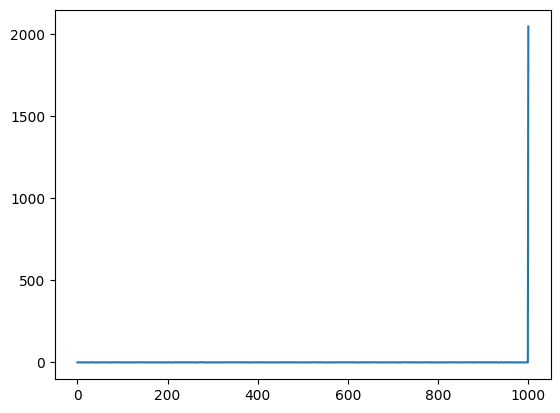

In [33]:
# len(out.post_samples)
plt.plot(np.transpose( post_samples.detach().cpu().numpy())[:,1] )
plt.show()


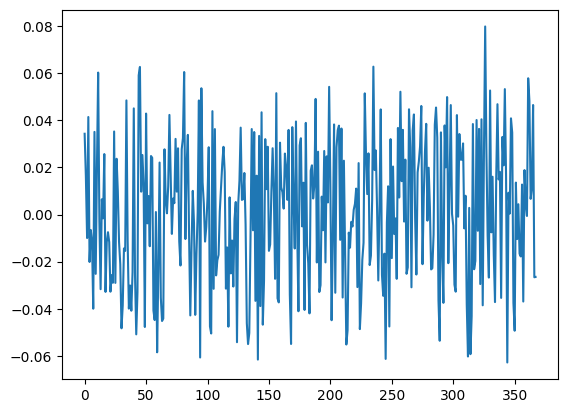

In [36]:
plt.plot(np.transpose( output_hits.detach().cpu().numpy())[:,1] )
plt.show()

In [82]:
model.encoder.n_latent_hierarchy_lvls

2

In [168]:
engine.model._flat_input_size
# engine.model.n_latent_hierarchy_lvls
# engine.model.n_latent_nodes
# engine._config

368

In [21]:
from models.networks.hierarchicalEncoderV2 import HierarchicalEncoderV2

In [54]:
heV2 = HierarchicalEncoderV2(
            input_dimension=engine.model._flat_input_size+1,
            n_latent_hierarchy_lvls=engine.model.n_latent_hierarchy_lvls,
            n_latent_nodes=engine.model.n_latent_nodes,
            skip_latent_layer=False,
            smoother="Gumbel",
            cfg=engine._config)
heV2 = heV2.to(dev)

In [58]:
heV2

HierarchicalEncoderV2(
  (_layers): ModuleList()
  (activation_fct): ReLU()
  (_networks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=369, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=450, bias=True)
      (3): ReLU()
      (4): Linear(in_features=450, out_features=400, bias=True)
      (5): ReLU()
      (6): Linear(in_features=400, out_features=350, bias=True)
      (7): ReLU()
      (8): Linear(in_features=350, out_features=300, bias=True)
      (9): ReLU()
      (10): Linear(in_features=300, out_features=1000, bias=True)
      (11): Identity()
    )
    (1): Sequential(
      (0): Linear(in_features=1369, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=450, bias=True)
      (3): ReLU()
      (4): Linear(in_features=450, out_features=400, bias=True)
      (5): ReLU()
      (6): Linear(in_features=400, out_features=350, bias=True)
      (7): ReLU()
      (8): Linear(in_

In [22]:
from models.networks.EncoderCNN import EncoderCNN

In [23]:
enCNN = EncoderCNN(
            input_dimension=engine.model._flat_input_size+1,
            n_latent_hierarchy_lvls=1, #engine.model.n_latent_hierarchy_lvls
            n_latent_nodes=engine.model.n_latent_nodes,
            skip_latent_layer=False,
            smoother="Gumbel",
            cfg=engine._config)
enCNN = enCNN.to(dev)

In [24]:
# result = enCNN(in_data)
enCNN

EncoderCNN(
  (_layers): ModuleList()
  (activation_fct): ReLU()
  (_networks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=369, out_features=576, bias=True)
      (1): Unflatten(dim=1, unflattened_size=(1, 24, 24))
      (2): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): PReLU(num_parameters=64)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): PReLU(num_parameters=128)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (9): PReLU(num_parameters=256)
      (10): LeakyReLU(negative_slope=0.02)
      (11): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
      (12): PReLU(num_parameters=512)
      (13): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
      (14): PReLU(num_parameters=1024)
      (15): MaxPool2d(kernel_size=2, stride=

In [108]:
from models.autoencoders.gumboltAtlasCRBMCNN import GumBoltAtlasCRBMCNN

In [27]:
# GumBoltAtlasCRBMCNN()

In [25]:
model.decoder

DecoderCNN(
  (_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1001, 1, 1))
    (1): ConvTranspose2d(1001, 512, kernel_size=(4, 4), stride=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=512)
    (4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2))
    (5): PReLU(num_parameters=256)
    (6): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=128)
  )
  (_activation_fct): ReLU()
  (_layers2): Sequential(
    (0): ConvTranspose2d(128, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): PReLU(num_parameters=32)
    (2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
    (3): PReLU(num_parameters=16)
    (4): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(1, 1))
    (5): Dropout(p=0.5, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)

In [68]:
z = model.decoder._layers(torch.rand(128,1001))

In [67]:
# z

In [70]:
enn = x[1]
torch.unsqueeze(enn, 2).shape
# enn.repeat(128,1,3,3).shape
# enn.unsqueeze(2).unsqueeze(3).repeat(1,1,3,3)
torch.cat((z, enn.cpu().unsqueeze(2).unsqueeze(3).repeat(1,1,21,21)), 1).shape

torch.Size([128, 129, 21, 21])

In [ ]:
###DEcoder

In [25]:
import torch.nn as nn

In [57]:
_layers = nn.Sequential(
                   nn.Unflatten(1, (1001, 1,1)),
    
                   nn.ConvTranspose2d(1001, 512, 4, 1, 0),
                   nn.BatchNorm2d(512),
                   nn.PReLU(512),

                   nn.ConvTranspose2d(512, 256, 4, 2, 0),
                   nn.PReLU(256),

                   nn.ConvTranspose2d(256, 128, 3, 2, 0),
                   nn.BatchNorm2d(128),
                   nn.PReLU(128),

                                   )

In [58]:
_layers(torch.rand(128,1001)).shape

torch.Size([128, 128, 21, 21])

In [59]:
_layers2 = nn.Sequential(
                   nn.ConvTranspose2d(128, 32, 2, 1, 0),
                   nn.PReLU(32),

                   nn.ConvTranspose2d(32, 16, 2, 1, 0),
                   nn.PReLU(16),

                   nn.ConvTranspose2d(16, 1, 2, 1, 0),
                   nn.Dropout(0.4),                  
    
                   nn.Flatten(),
                   nn.Linear(576,368),
                                   )

In [60]:
_layers2(torch.rand(128,128,21,21)).shape

torch.Size([128, 368])

In [61]:
nn.functional.linear(torch.rand(128,576), torch.rand(368,576))

tensor([[147.5487, 142.3052, 136.9781,  ..., 154.2853, 145.3901, 144.4370],
        [148.4435, 144.5593, 142.4695,  ..., 153.2279, 145.1935, 145.7170],
        [150.9962, 147.4809, 143.3409,  ..., 156.9807, 151.1649, 148.0030],
        ...,
        [143.6592, 143.9144, 139.3793,  ..., 150.2607, 140.4507, 146.7038],
        [144.8691, 139.4242, 138.5883,  ..., 148.5443, 142.7310, 141.6716],
        [155.4580, 152.4474, 147.5072,  ..., 160.5548, 153.9460, 155.4306]])